This Notebook contains a sample of data visualisation plots used within my dissertation work

In [348]:
# Imports
import string
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas.plotting import scatter_matrix

from tqdm import tqdm_notebook
tqdm_notebook().pandas()
from tqdm.notebook import tqdm

from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from gensim.models import word2vec
from gensim.models import Phrases
from sklearn.manifold import TSNE


# Profile Data Visualisation [1.0]

In [2]:
# Get Data
df_profile = pd.read_csv('basic_profile_data.csv')
df_profile.columns

Index(['UserID', 'createdAt', 'CollectedAt', 'NumberOfFollowings',
       'NumberOfFollowers', 'NumberOfTweets', 'LengthOfScreenName',
       'LengthOfDescriptionInUserProfile', 'SeriesOfNumberOfFollowings',
       'LangCount', 'userType'],
      dtype='object')

In [115]:
# Preview of dataset
# UserIDs are hidden for privacy reasons
df_profile[df_profile.columns.difference(['UserID'])].head(3)

,CollectedAt,LangCount,LengthOfDescriptionInUserProfile,LengthOfScreenName,NumberOfFollowers,NumberOfFollowings,NumberOfTweets,SeriesOfNumberOfFollowings,createdAt,userType
0,19/11/2009 05:10,19,0,7,39,41,912,[25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 2...,10/03/2009 01:35,0
1,22/11/2009 23:42,2,34,11,885,2000,710,[1998. 1998. 1998. 1997. 1997. 1997. 1997. 199...,03/03/2009 11:51,0
2,14/11/2009 06:25,7,0,9,31,92,828,[119. 119. 119. 119. 119. 119. 119. 119. 119. ...,20/03/2009 19:43,0


<h3>Split of Users [1.1]</h3>

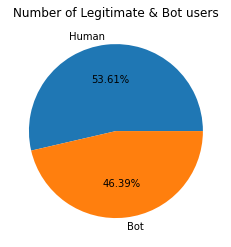

In [24]:
# Get number of unique values
values = list(df_profile['userType'].value_counts())

# Build plot
plt.pie(values, labels = ['Human','Bot'], autopct='%1.2f%%')
plt.title('Number of Legitimate & Bot users')
plt.show()

<h3>Mean Number of Followings for Humans/Bots [1.2]</h3>

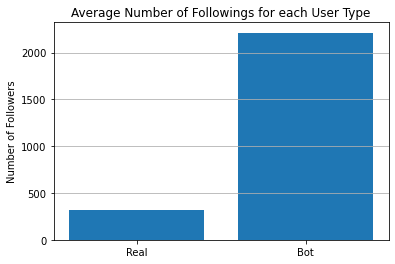

In [34]:
# Get mean of each userType
data = list(df_profile.groupby(['userType'])['NumberOfFollowings'].mean())

# Build plot
fig, ax = plt.subplots()
ax.bar(['Real','Bot'], data, align='center')
ax.set_ylabel('Number of Followers')
ax.set_title('Average Number of Followings for each User Type')
ax.yaxis.grid(True)

plt.show()

<h3>Distribution of Humans/Bots Tweets [1.3]</h3>
    
Typically this will be tested for a range of features, however to ensure easy viewing only 1 version will be shown.

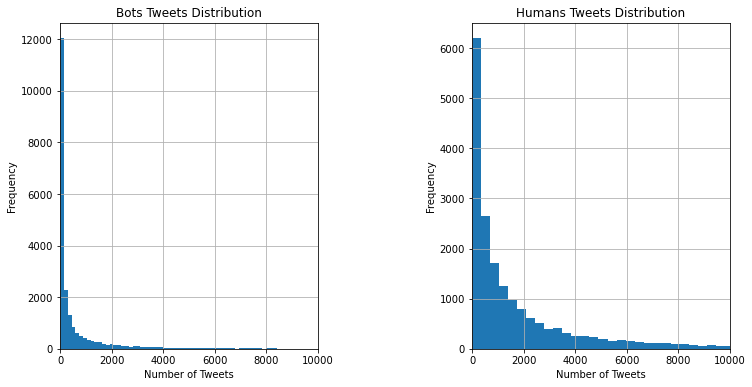

In [77]:
fig, axes = plt.subplots(1, 2)

# Adjusting output size
fig.set_figheight(6)
fig.set_figwidth(12)
fig.subplots_adjust(wspace=0.6)

# Data for hist plots
df_profile[df_profile['userType'] == 1]['NumberOfTweets'].hist(bins=1000, ax=axes[0])
df_profile[df_profile['userType'] == 0]['NumberOfTweets'].hist(bins=1000, ax=axes[1])

for i in range(2):
    # X limit set so the main distribution is more visable
    axes[i].set_xlim(xmin=0.0, xmax = 10000)
    axes[i].set_xlabel("Number of Tweets")
    axes[i].set_ylabel("Frequency")
    if (i == 0):
        axes[i].set_title("Bots Tweets Distribution")
    else:
        axes[i].set_title("Humans Tweets Distribution")

plt.show()

Typically Machine Learning models perform better when there is a normal distribution. To see if this can be crafted each value is logged.

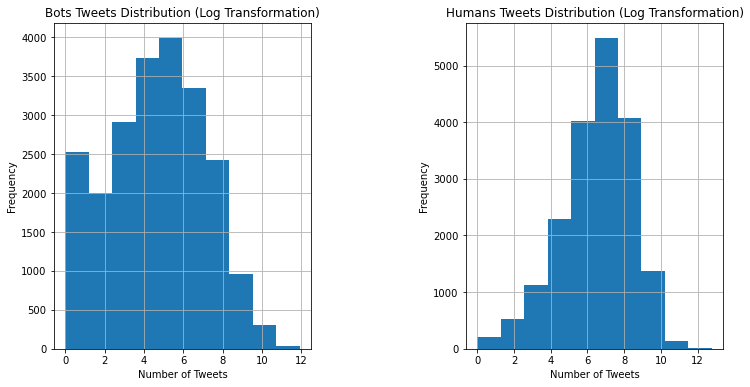

In [102]:
# As there is some 0 values I perform log(x + 1)
bots_tweets_log = np.log(df_profile[df_profile['userType'] == 1]['NumberOfTweets'] + 1)
humans_tweets_log = np.log(df_profile[df_profile['userType'] == 0]['NumberOfTweets'] + 1)

fig, axes = plt.subplots(1, 2)

# Adjusting output size
fig.set_figheight(6)
fig.set_figwidth(12)
fig.subplots_adjust(wspace=0.6)

# Data for hist plots
bots_tweets_log.hist(bins=10, ax=axes[0])
humans_tweets_log.hist(bins=10, ax=axes[1])

for i in range(2):
    axes[i].set_xlabel("Number of Tweets")
    axes[i].set_ylabel("Frequency")
    if (i == 0):
        axes[i].set_title("Bots Tweets Distribution (Log Transformation)")
    else:
        axes[i].set_title("Humans Tweets Distribution (Log Transformation)")

plt.show()

<h3>Correlation Heatmap [1.4]</h3>

<AxesSubplot:>

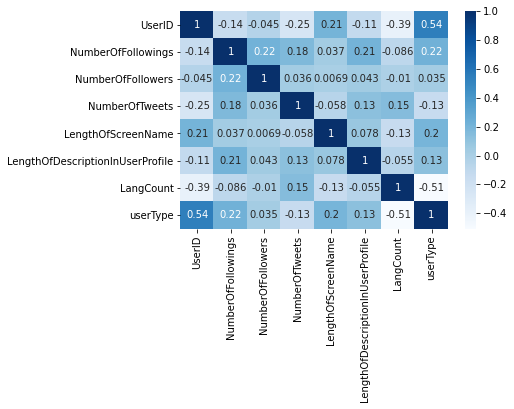

In [107]:
# Calculate correlation
corr = df_profile.corr()
# Build Plot
sns.heatmap(corr, cmap="Blues", annot=True)

<h3>Normalised Users Following Overtime [1.5]</h3>

In [20]:
# Convert time series from string format to array
df_profile['SeriesOfNumberOfFollowings'] = df_profile['SeriesOfNumberOfFollowings'].apply(lambda x: 
                           np.fromstring(
                               x.replace('\n','')
                                .replace('[','')
                                .replace(']','')
                                .replace('  ',' '), sep=' ').tolist())

# Padding each time series to ensure they are all the length of 230
# For series less than 230, the last value in the series is elongated to reach the length of 230
def series_elongate(x, maxlen=230):
    if (len(x) < maxlen):
        last_value = x[len(x) - 1]
        x += [last_value] * (maxlen-len(x))    
    return np.array(x)

df_profile['SeriesOfNumberOfFollowings'] = df_profile['SeriesOfNumberOfFollowings'].apply(series_elongate)


# Get Average value for each position in time series for bots/humans
human_series_average = np.average(df_profile[df_profile['userType'] == 0]['SeriesOfNumberOfFollowings'], axis=0)
bots_series_average = np.average(df_profile[df_profile['userType'] == 1]['SeriesOfNumberOfFollowings'], axis=0)

# Normalise to ensure data are on same scale
norm_human = (human_series_average-human_series_average.min())/(human_series_average.max()-human_series_average.min())
norm_bots = (bots_series_average-bots_series_average.min())/(bots_series_average.max()-bots_series_average.min())

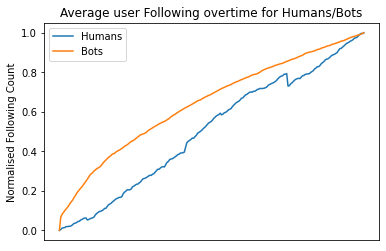

In [23]:
maxlen = 230
# Build plot
plt.plot(list(range(1, (maxlen + 1))), norm_human, label='Humans')
plt.plot(list(range(1, (maxlen + 1))), norm_bots, label='Bots')
# Plot Settings
plt.title('Average user Following overtime for Humans/Bots')
plt.ylabel('Normalised Following Count')
plt.legend()
plt.xticks([])

plt.show()

# Text Data Visualisation [2.0]

In [3]:
# Get Data
df_tweets = pd.read_csv('basic_tweet_data.csv')
df_tweets.columns

Index(['UserID', 'TweetID', 'Tweet', 'CreatedAt', 'userType'], dtype='object')

In [8]:
# Preview of dataset
# UserIDs, TweetID are hidden for privacy reasons
df_tweets[df_tweets.columns.difference(['UserID','TweetID'])].head(3)

,CreatedAt,Tweet,userType
0,2009-11-20 23:52:52,… at house party in Daybreak. Not as weird as ...,0
1,2009-11-20 20:42:48,Taxiing — at SLC Salt Lake City International...,0
2,2009-11-20 18:11:01,Almost home! — at PDX Portland International ...,0


<h3>Basic Text Pre-Processing [2.0]</h3>

In [349]:
# Text Basic Pre-Processing
def clean_text(text):
    text = str(text)
    # Remove URL, RT, mention(@)
    # (there is many link variations within the dataset)
    text = re.sub(r'www\.\S+\.com', '',text)
    text = re.sub(r'\S+\.com', '',text)
    text = re.sub(r'www\.\S+', '',text)
    text=  re.sub(r'http(\S)+', ' ',text)
    text=  re.sub(r'http ...', ' ',text)
    text=  re.sub(r'(RT|rt)[ ]*@[ ]*[\S]+',' ',text)
    text=  re.sub(r'RT[ ]?@',' ',text)
    text = re.sub(r'@[\S]+',' ',text)
    # Remove all numbers and symbols
    text = text.translate(str.maketrans('','',string.punctuation))
    text = text.translate(str.maketrans('','','1234567890'))
    return text.lower().strip()

# Basic Text Pre-Processing
df_tweets['cleanTweet'] = df_tweets['Tweet'].progress_apply(clean_text)

# Remove Stopwords
nltk.download('punkt')
nltk.download('stopwords')
cachedStopWords = stopwords.words("english")

# Tokenize and remove stopwords
df_tweets['cleanTweetTokens'] = df_tweets['cleanTweet'].progress_apply(lambda x: word_tokenize(str(x)))
df_tweets['cleanTweetTokens'] = df_tweets['cleanTweetTokens'].progress_apply(lambda x: [item for item in x if item not in cachedStopWords])



<h3>Word Frequency and Similarity Bubble Chart [2.1]</h3>
To create this model a Word2Vec model is trained on the dataset and then t-SNE is used to represent the data in 2 dimensions. This creates a chart where similar bigrams will be closer to each other and the circle size depends on the frequency of the particular bigram.

In [152]:
def select_top_k(max_features, user_type):
    print(f'Selecting Top', max_features, 'Bigrams')
    # Calculate Bigram BoW for each word in dataset
    vectorizer = CountVectorizer(stop_words = 'english', ngram_range=(2,2), max_features=max_features)
    X_BoWTrans = vectorizer.fit_transform(df_tweets[df_tweets['userType'] == user_type]['cleanTweet'])
    
    word_sum = X_BoWTrans.sum(axis=0)
    
    # Add the Word and word sum in tuple
    # The "term" variable needs to be changed so instead of "blog post" its "blog_post" (for use of bigram with word2vec)
    data = []
    for col, term in enumerate(vectorizer.get_feature_names()):
        data.append( (term.replace(" ", "_"), word_sum[0,col] ))
    
    return sorted(data, key=lambda x: x[1])

def create_tsne_plot(model, title_text, max_features=100, user_type=0):
    labels = []
    features = []
    markerSize = []
    counter = 0
    # Selecting top k words for printing on graph
    words = select_top_k(max_features, user_type)
    
    for word in words:
        try:
            features.append(model.wv[word[0]])
            labels.append(word[0])
            markerSize.append(word[1])
        except:
            counter += 1
        
    print(counter, "words not found in Word2Vec Model")
    print(f'Processing T-SNE')
    tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_values = tsne_model.fit_transform(features)

    # Create x/y axis list for plot
    x = []
    y = []
    for value in plot_values:
        x.append(value[0])
        y.append(value[1])
    
    # Build Plot    
    plt.figure(figsize=(16, 16))
    plt.title(title_text)
    for i in range(len(x)):
        plt.scatter(x[i],y[i],s=markerSize[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(0, 0),
                     textcoords='offset points',
                     ha='right')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    

Selecting Top 100 Bigrams
40 words not found in Word2Vec Model
Processing T-SNE


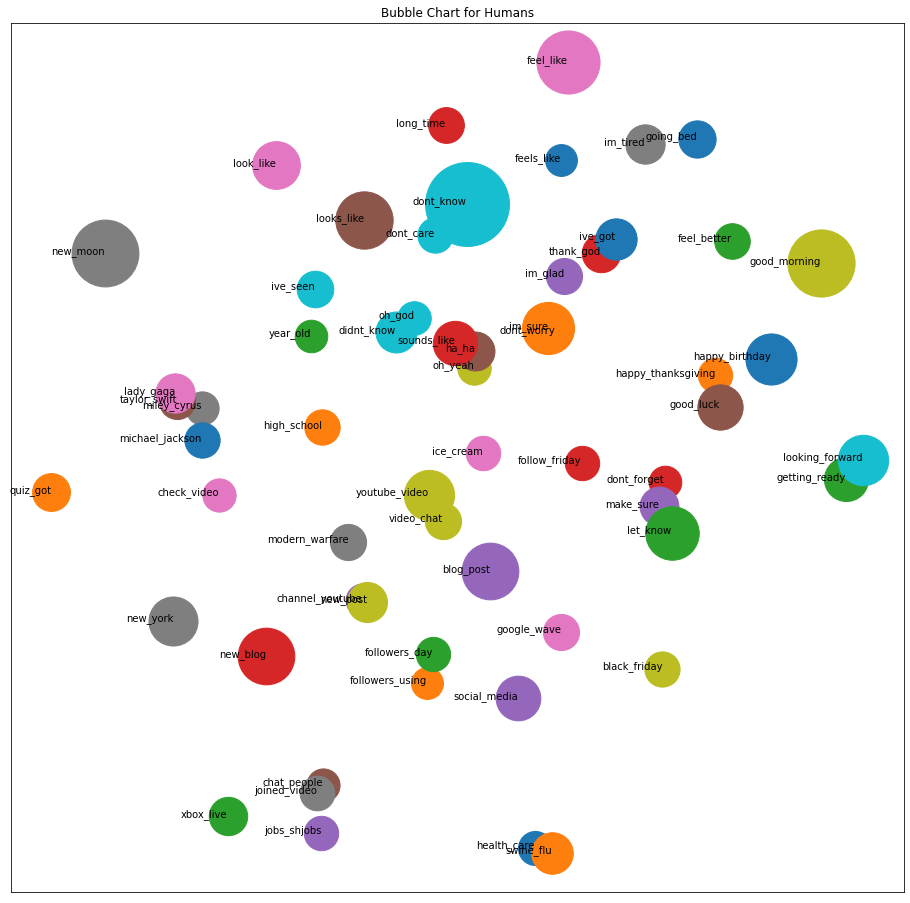

In [154]:
corpus_humans = df_tweets[df_tweets['userType'] == 0]['cleanTweetTokens']

bigram_transformer = Phrases(corpus_humans, min_count=1)

# Train a Word2Vec Model for Word Similarity Graphs
model = word2vec.Word2Vec(bigram_transformer[corpus_humans], vector_size=100, min_count=5, workers=4)

# Create t-SNE Plot for Humans
create_tsne_plot(model, title_text='Bubble Chart for Humans', max_features=100, user_type=0)

Selecting Top 100 Bigrams
13 words not found in Word2Vec Model
Processing T-SNE


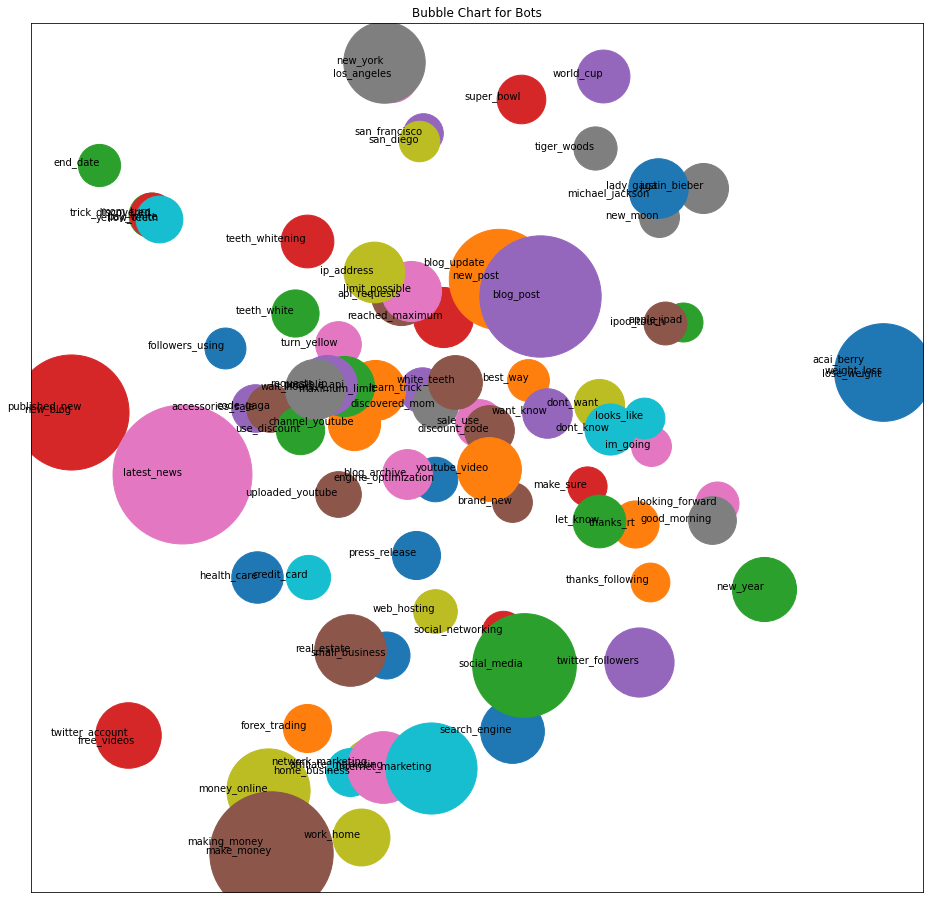

In [155]:
corpus_bots = df_tweets[df_tweets['userType'] == 1]['cleanTweetTokens']

bigram_transformer = Phrases(corpus_bots, min_count=1)

# Train a Word2Vec Model for Word Similarity Graphs
model = word2vec.Word2Vec(bigram_transformer[corpus_bots], vector_size=100, min_count=5, workers=4)

# Create t-SNE Plot for Bots
create_tsne_plot(model, title_text='Bubble Chart for Bots', max_features=100, user_type=1)

<h3>Bi-directional Bar Graph [2.2]</h3>

In [350]:
def tf_score_ranking(userType):
    vectorizer = TfidfVectorizer(min_df=5, max_df = 0.95, stop_words = 'english', ngram_range=(3,3))
    transformed_data = vectorizer.fit_transform(df_tweets[df_tweets['userType'] == userType]['cleanTweet'])
    # Sum tfidf frequency of each term through documents
    sums = transformed_data.sum(axis=0)
    terms = vectorizer.get_feature_names()
    # Connecting terms to its sums frequency
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col] ))

    return sorted(data, key=lambda x: x[1])[::-1]


def get_common_words(humans, bots, N=500):
    human_top_N_grams = [x[0] for x in humans][:N]
    bot_top_N_grams = [x[0] for x in bots][:N]
    return list(set(bot_top_N_grams) & set(human_top_N_grams))


def create_tfidf_scores(common_words, humans, bots):
    # find the word and then the score in humans and bots list
    # in form (word, bot score, human score)
    tfidf_word_scores = []
    for word in common_words:
        bot_score = [x[1] for x in bots if x[0] == word][0]
        human_score = [x[1] for x in humans if x[0] == word][0]
        tfidf_word_scores.append((word,bot_score,human_score)) 
    return tfidf_word_scores

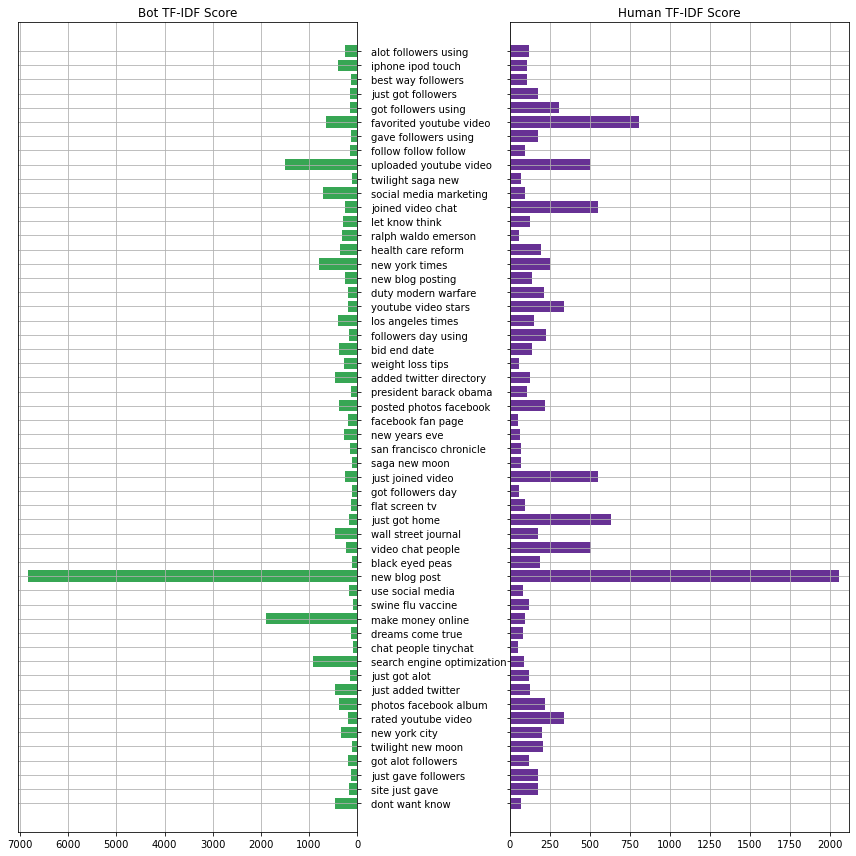

In [221]:
# Get Rankings
data_humans = tf_score_ranking(0)
data_bot = tf_score_ranking(1)

# Get list of common words
common_words = get_common_words(data_humans, data_bot)

# Get tuples of tfidf scores for common words
tfidf_word_scores = create_tfidf_scores(common_words, data_humans, data_bot)

# Data for Figure
words = [x[0] for x in tfidf_word_scores]
bot_scores = [x[1] for x in tfidf_word_scores]
human_scores = [x[2] for x in tfidf_word_scores]

# Build Figure
fig, axes = plt.subplots(figsize=(12,12), ncols=2, sharey=True)
# Add data
axes[0].barh(words, bot_scores, align='center', color='#37a654')
axes[1].barh(words, human_scores, align='center', color='#673194')
# Set titles
axes[0].set(title='Bot TF-IDF Score')
axes[1].set(title='Human TF-IDF Score')
# Fix y-axis
axes[0].invert_xaxis()
axes[0].yaxis.tick_right()
axes[0].tick_params(axis='y', which='major', pad=10)

for ax in axes.flat:
    ax.margins(0.03)
    ax.grid(True)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.45)

plt.show()


<h3> Number of Tweets by Humans/Bots Every Month [2.3]</h3>

In [245]:
# Convert column to date formart
df_tweets['CreatedAt'] = pd.to_datetime(df_tweets['CreatedAt']).dt.date

In [299]:
# List of dates for bots
x = sorted(df_tweets['CreatedAt'].unique())
earlist = x[0]
latest = x[len(x) - 1]

monthly_interval_list = pd.date_range(start=earlist,end=latest, freq='MS').date.tolist()

In [339]:
# Create a list containing the number of tweets for each month for both bots and humans.
bot_monthly_tweets = []
humans_monthly_tweets = []

for i in range(0, len(monthly_interval_list)):
    if (i == (len(monthly_interval_list) - 1)):
        sample = df_tweets[(df_tweets['CreatedAt'] >= monthly_interval_list[i])]
        bot_monthly_tweets.append(sample[sample['userType'] == 1].shape[0])
        humans_monthly_tweets.append(sample[sample['userType'] == 0].shape[0])
        break
    sample = df_tweets[(df_tweets['CreatedAt'] >= monthly_interval_list[i]) & (df_tweets['CreatedAt'] < monthly_interval_list[(i+1)])]
    bot_monthly_tweets.append(sample[sample['userType'] == 1].shape[0])
    humans_monthly_tweets.append(sample[sample['userType'] == 0].shape[0])
    
bot_monthly_tweets = np.array(bot_monthly_tweets)
humans_monthly_tweets = np.array(humans_monthly_tweets)



As the last 9 values in the list "humans_monthly_tweets" have the value of 0, they are removed from the graph to make a more clearer comparison. And as the scales are different, both lists are normalised.

In [343]:
bot_monthly_tweets = bot_monthly_tweets[:len(bot_monthly_tweets) - 9]
humans_monthly_tweets = humans_monthly_tweets[:len(humans_monthly_tweets) - 9]
monthly_interval_list = monthly_interval_list[:len(monthly_interval_list) - 9]

bot_monthly_tweets_norm = (bot_monthly_tweets-bot_monthly_tweets.min())/(bot_monthly_tweets.max()-bot_monthly_tweets.min())
humans_monthly_tweets_norm = (humans_monthly_tweets-humans_monthly_tweets.min())/(humans_monthly_tweets.max()-humans_monthly_tweets.min())


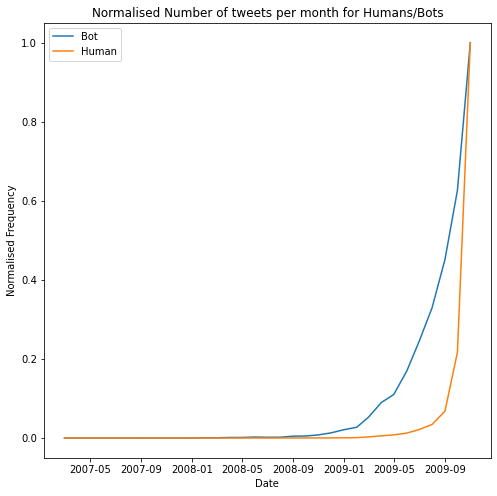

In [347]:
plt.figure(figsize=(8, 8))
plt.plot(monthly_interval_list,bot_monthly_tweets_norm, label='Bot')
plt.plot(monthly_interval_list,humans_monthly_tweets_norm, label='Human')
plt.title('Normalised Number of tweets per month for Humans/Bots')
plt.xlabel('Date')
plt.ylabel('Normalised Frequency')
plt.legend()
plt.show()